In [438]:
!cd ../../src

In [439]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [440]:
%autoreload 2

In [441]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Plots
font = {
    'size': 22
}
plt.rc('font', **font)

In [442]:
# Experiment
group = "combined"  # "controlled" or "free" or "combined"
pos = "adjectives"  # "nouns" or "adjectives"
features = "count"  # "tfidf" or "count"

### Load signal feature matrix

In [443]:
from src.utils import features_dir

# Load signal features
df_signal = pd.read_csv(features_dir() / "signal" / "handmade" / "features.csv")
df_signal = df_signal.div(df_signal.max(axis=0))
df_signal.head()

,id,mean_amplitude,rms,pulse_count,std_pulse_dist,zero_count,mean_onset_strength,spectral_centroid
0,0.03125,-0.143573,0.245610,0.582090,0.059303,0.483934,0.480730,0.697118
1,0.06250,0.003106,0.194246,0.358209,0.728836,0.586410,0.245436,0.941312
2,0.09375,0.015928,0.266699,0.179104,0.451720,0.566796,0.267748,0.722002
3,0.12500,0.478377,0.371489,0.805970,0.121914,0.639993,0.590264,0.528029
4,0.15625,0.637004,0.077705,0.477612,0.554012,0.114460,0.026369,0.741160


### Load linguistic feature matrices

In [444]:
from src.utils import features_dir

# Load concept features
df_concept = pd.read_csv(features_dir() / "linguistic" / f"{group}_{pos}_{features}.csv")
df_concept = df_concept.div(df_concept.max(axis=0))

df_to_save = df_concept.round(4)
df_to_save.to_csv(features_dir() / "linguistic" / f"{group}_{pos}_{features}_norm.csv", index=False)

df_concept.head()

,id,ConstAdj1,ConstAdj2,ConstAdj3,ConstAdj4,ConstAdj5,ConstAdj6,ConstAdj7,ConstAdj8,ConstAdj9,ConstAdj10
0,0.03125,0.611111,0.6,0.333333,1.0,0.00,0.25,0.2,0.00,1.0,0.333333
1,0.06250,0.888889,0.2,0.000000,0.0,0.00,0.75,0.2,0.25,0.0,0.000000
2,0.09375,0.444444,0.2,0.000000,0.0,0.50,0.25,0.4,0.00,0.0,0.166667
3,0.12500,0.388889,0.2,0.333333,0.0,0.25,1.00,0.2,0.00,0.0,0.166667
4,0.15625,0.666667,0.2,0.000000,0.5,0.50,0.25,0.0,0.00,0.0,0.166667


### Correlate signal - concept

In [445]:
df_combined = pd.concat([df_signal, df_concept], axis=1)
df_combined = df_combined.drop(columns=["id"])
df_combined.head()

,mean_amplitude,rms,pulse_count,std_pulse_dist,zero_count,mean_onset_strength,spectral_centroid,ConstAdj1,ConstAdj2,ConstAdj3,ConstAdj4,ConstAdj5,ConstAdj6,ConstAdj7,ConstAdj8,ConstAdj9,ConstAdj10
0,-0.143573,0.245610,0.582090,0.059303,0.483934,0.480730,0.697118,0.611111,0.6,0.333333,1.0,0.00,0.25,0.2,0.00,1.0,0.333333
1,0.003106,0.194246,0.358209,0.728836,0.586410,0.245436,0.941312,0.888889,0.2,0.000000,0.0,0.00,0.75,0.2,0.25,0.0,0.000000
2,0.015928,0.266699,0.179104,0.451720,0.566796,0.267748,0.722002,0.444444,0.2,0.000000,0.0,0.50,0.25,0.4,0.00,0.0,0.166667
3,0.478377,0.371489,0.805970,0.121914,0.639993,0.590264,0.528029,0.388889,0.2,0.333333,0.0,0.25,1.00,0.2,0.00,0.0,0.166667
4,0.637004,0.077705,0.477612,0.554012,0.114460,0.026369,0.741160,0.666667,0.2,0.000000,0.5,0.50,0.25,0.0,0.00,0.0,0.166667


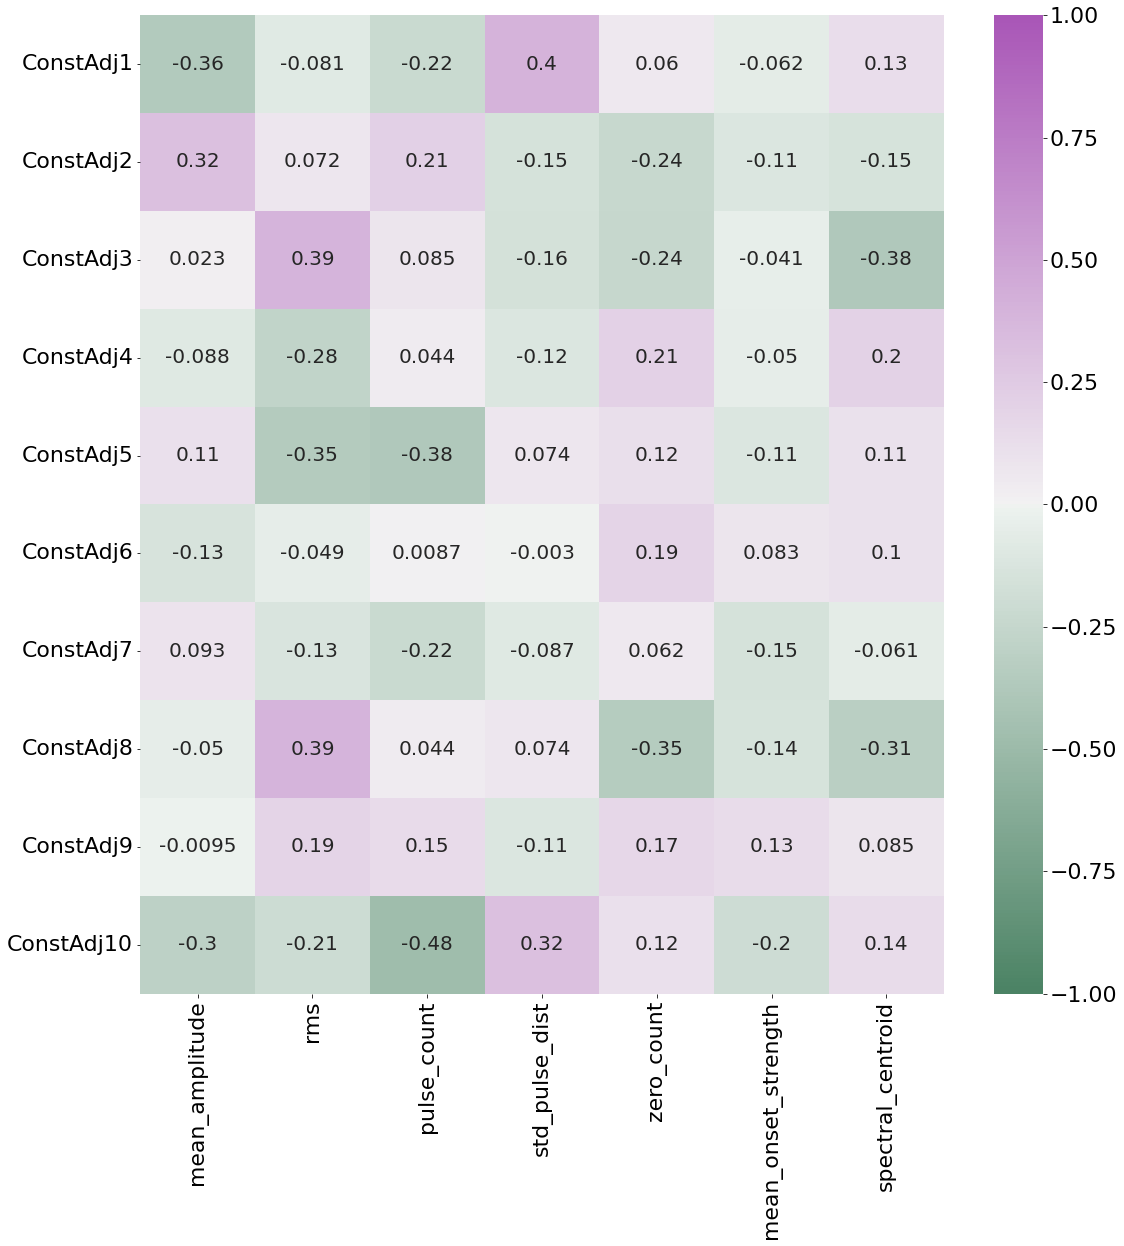

In [446]:
import seaborn as sns
from src.utils import plots_dir, results_dir

f, ax = plt.subplots(figsize=(18, 18))
corr = df_combined.corr()

# Only select signal columns
signal_columns = [column for column in df_signal.columns if column != "id"]
corr = corr[signal_columns]

# Only select concept rows
concept_indices = [column for column in df_concept.columns if column != "id"]
corr = corr.loc[concept_indices]

rounded = corr.round(4).sort_index()
rounded.to_csv(results_dir() / "correlations" / f"{group}_{pos}_{features}.csv")

# Color palettes:
# sns.color_palette("vlag", as_cmap=True)
# sns.diverging_palette(145, 300, s=60, as_cmap=True)
heatmap = sns.heatmap(corr,
                      mask=np.zeros_like(corr, dtype=bool),
                      cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
                      square=False,
                      annot=True,
                      annot_kws={ "size": 20 },
                      vmin=-1,
                      vmax=1,
                      fmt=".2g",
                      ax=ax)
ax.tick_params(axis='y', rotation=0)
fig = heatmap.get_figure()
path = plots_dir() / "correlations" / f"{group}_{pos}_pearson_corr_matrix.png"
fig.savefig(path,
            bbox_inches='tight',
            transparent=False,
            pad_inches=0,
            dpi=300)

In [447]:
import pingouin as pg

df = pg.pairwise_corr(df_combined, method="pearson").round(3)
df = df[df["p-unc"] < 0.05]
df

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
3,mean_amplitude,zero_count,pearson,two-sided,32,-0.351,"[-0.62, -0.0]",0.049,1.416,0.517
6,mean_amplitude,ConstAdj1,pearson,two-sided,32,-0.362,"[-0.63, -0.02]",0.042,1.597,0.543
16,rms,pulse_count,pearson,two-sided,32,0.559,"[0.26, 0.76]",0.001,43.228,0.931
17,rms,std_pulse_dist,pearson,two-sided,32,-0.364,"[-0.63, -0.02]",0.040,1.641,0.549
18,rms,zero_count,pearson,two-sided,32,-0.535,"[-0.74, -0.23]",0.002,25.495,0.902
20,rms,spectral_centroid,pearson,two-sided,32,-0.657,"[-0.82, -0.4]",0.000,639.46,0.990
23,rms,ConstAdj3,pearson,two-sided,32,0.391,"[0.05, 0.65]",0.027,2.301,0.616
25,rms,ConstAdj5,pearson,two-sided,32,-0.353,"[-0.62, -0.01]",0.047,1.445,0.522
28,rms,ConstAdj8,pearson,two-sided,32,0.394,"[0.05, 0.65]",0.026,2.389,0.624
31,pulse_count,std_pulse_dist,pearson,two-sided,32,-0.758,"[-0.88, -0.56]",0.000,3.792e+04,1.000
